<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

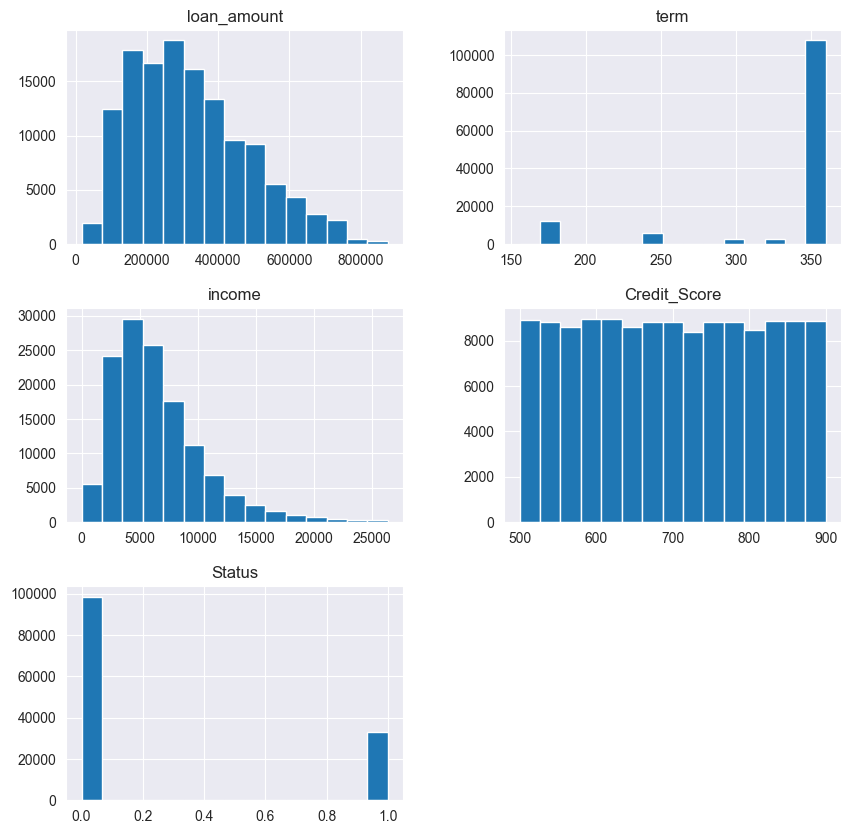

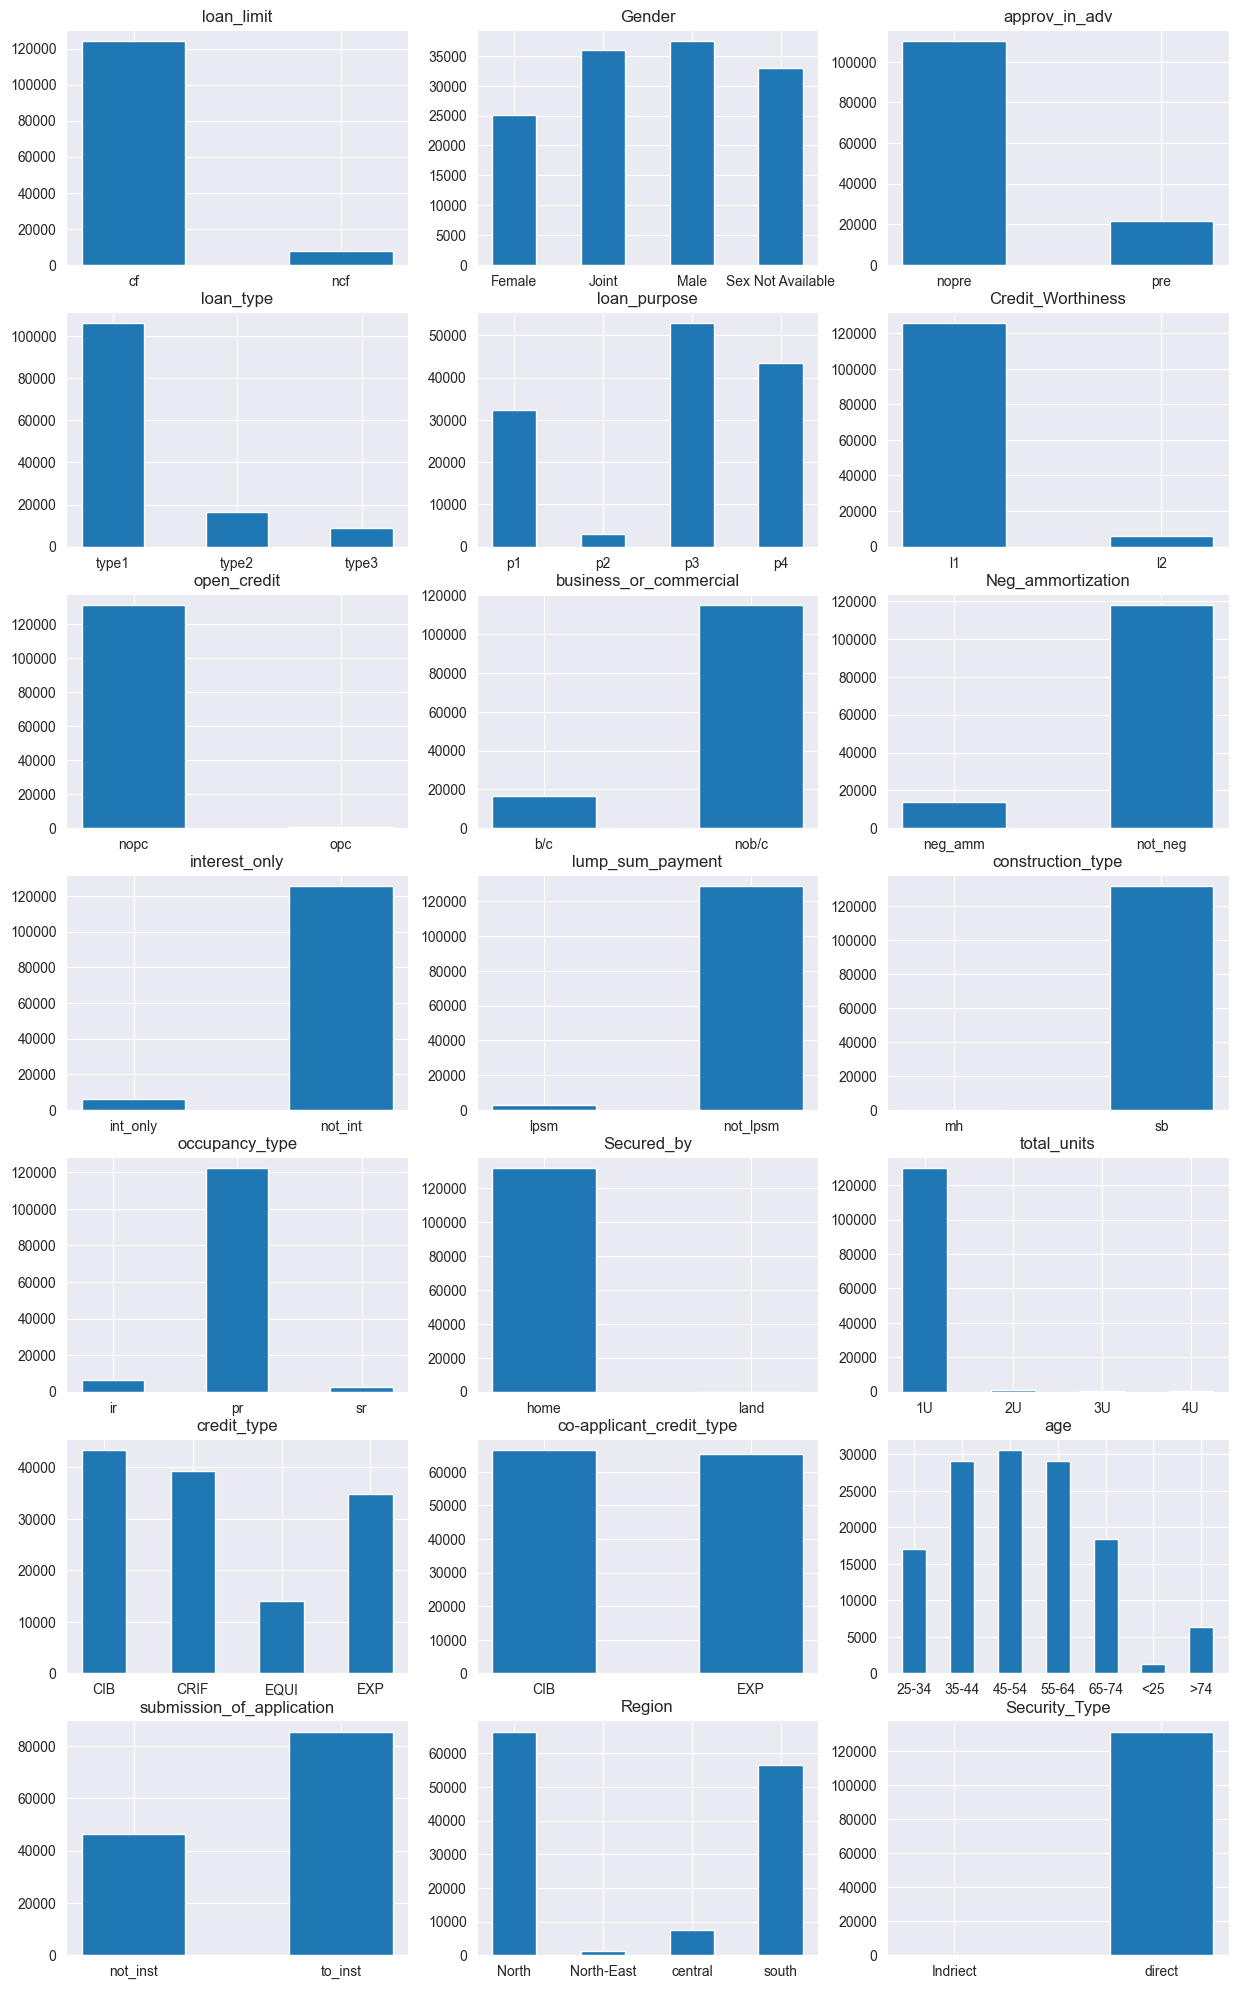

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("../data/Loan_Default.csv") # Read Data
data.info()

# drop the columns with too much null values in Status == 1
data = data.drop(["rate_of_interest", "Interest_rate_spread", "Upfront_charges", "property_value", "LTV", "dtir1"], axis=1)

# drop the useless columns.
data = data.drop(["ID", "year"], axis=1)

# drop the lines with null values.
data = data.dropna(axis=0, how="any")

# Remove exact duplicate rows
data = data.drop_duplicates()

# Detect and remove outliers using Z-score
from scipy import stats
import numpy as np

# Select numeric columns only
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Compute Z-scores (ignoring NaNs)
z_scores = np.abs(stats.zscore(data[numeric_cols], nan_policy='omit'))

# Set threshold (commonly 3)
threshold = 3

# Keep only rows where all numeric Z-scores are below the threshold
data = data[(z_scores < threshold).all(axis=1)]

print("Shape of data after removing duplicates and outliers:", data.shape)



# check the distribution of numeric columns.
data.hist(bins=15, figsize=(10,10))
plt.show()

# check the distribution of non-numeric columns.
object_list = list(data.columns[data.dtypes == "object"])
fig = plt.figure(figsize=(15,25))
n = 1
for column in object_list:
    d = pd.DataFrame(data.loc[:, [column, "Status"]]).groupby(column).count()["Status"]
    ax = fig.add_subplot(7, 3, n)
    ax.bar(height=d, x=[i for i in range(len(d))], width = 0.5)
    ax.set_xticks([i for i in range(len(d))])
    ax.set_xticklabels(list(d.index))
    ax.set_title(column)
    n +=1
plt.show()


In [53]:
# drop the columns with extreme distributions, which are useless for predicting.
data = data.drop(["Security_Type", "total_units", "construction_type", "open_credit", "Secured_by", "income"], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131684 entries, 0 to 148669
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 131684 non-null  object 
 1   Gender                     131684 non-null  object 
 2   approv_in_adv              131684 non-null  object 
 3   loan_type                  131684 non-null  object 
 4   loan_purpose               131684 non-null  object 
 5   Credit_Worthiness          131684 non-null  object 
 6   business_or_commercial     131684 non-null  object 
 7   loan_amount                131684 non-null  int64  
 8   term                       131684 non-null  float64
 9   Neg_ammortization          131684 non-null  object 
 10  interest_only              131684 non-null  object 
 11  lump_sum_payment           131684 non-null  object 
 12  occupancy_type             131684 non-null  object 
 13  credit_type                131684 

# 为什么要删除首列（防止过拟合）
在独热编码中，每个分类变量会被转换为多个二进制（0或1）列。例如，性别列中的值 "Male" 和 "Female" 会被转换为两个列 "Gender_Male" 和 "Gender_Female"。如果我们保留所有这些列，可能会导致多重共线性问题，即这些列之间存在高度相关性。

删除首列的原因是为了避免多重共线性。具体来说，如果我们有一个包含
k 个不同类别的分类变量，我们只需要 k−1 个二进制列来表示这些类别。
删除首列可以确保这些新生成的二进制列是线性独立的，从而防止过拟合。

In [54]:
# change the object columns into one-hot coding.
dummy_list = list(data.columns[data.dtypes == "object"])
for i in dummy_list:
    data = pd.concat([data, pd.get_dummies(data[i]).iloc[:, 1:]], axis=1)
    data.drop(i, axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131684 entries, 0 to 148669
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loan_amount        131684 non-null  int64  
 1   term               131684 non-null  float64
 2   Credit_Score       131684 non-null  int64  
 3   Status             131684 non-null  int64  
 4   ncf                131684 non-null  bool   
 5   Joint              131684 non-null  bool   
 6   Male               131684 non-null  bool   
 7   Sex Not Available  131684 non-null  bool   
 8   pre                131684 non-null  bool   
 9   type2              131684 non-null  bool   
 10  type3              131684 non-null  bool   
 11  p2                 131684 non-null  bool   
 12  p3                 131684 non-null  bool   
 13  p4                 131684 non-null  bool   
 14  l2                 131684 non-null  bool   
 15  nob/c              131684 non-null  bool   
 16  not_neg

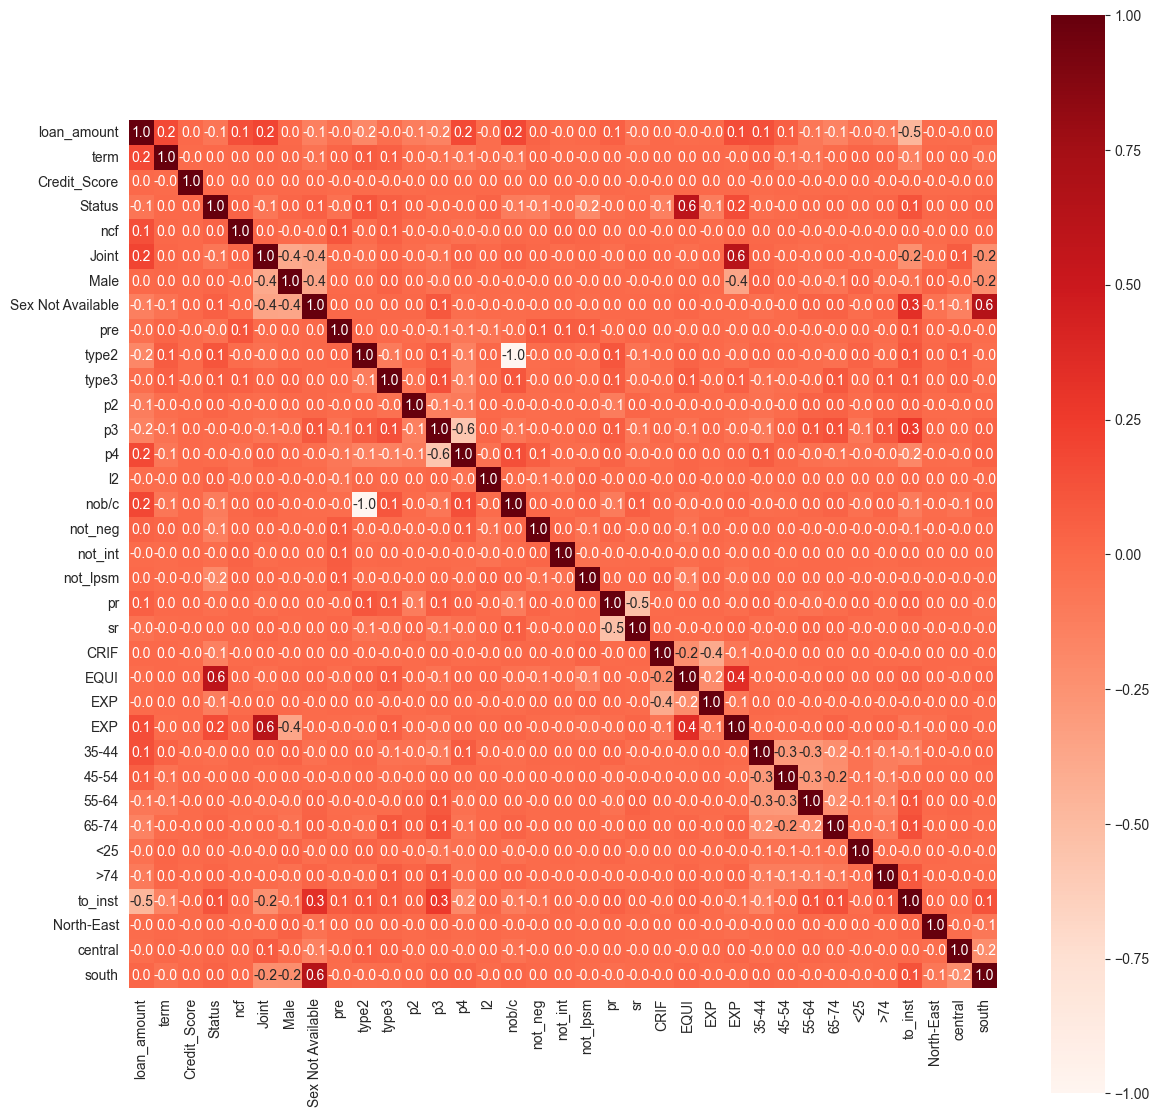

In [55]:
# find the correlation between columns.

import seaborn as sns

corr = data.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, cmap='Reds',square=True, fmt=".1f")
plt.show()

# 删除相关系数为正负一的列
删除相关系数为正负1的列是为了避免多重共线性问题。多重共线性是指在回归分析中，两个或多个解释变量之间存在高度相关性，这会导致以下问题：

模型不稳定：当解释变量之间存在高度相关性时，回归系数的估计值会变得不稳定，可能会出现较大的标准误差，导致模型的预测能力下降。
解释困难：高度相关的变量会使得解释回归系数变得困难，因为很难确定哪个变量对因变量的影响更大。
冗余信息：高度相关的变量提供了重复的信息，删除其中一个不会损失信息量，反而可以简化模型，提高模型的可解释性。

In [56]:
# drop the columns with co-relations that are too high.
data = data.drop(["type2"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131684 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loan_amount        131684 non-null  int64  
 1   term               131684 non-null  float64
 2   Credit_Score       131684 non-null  int64  
 3   Status             131684 non-null  int64  
 4   ncf                131684 non-null  bool   
 5   Joint              131684 non-null  bool   
 6   Male               131684 non-null  bool   
 7   Sex Not Available  131684 non-null  bool   
 8   pre                131684 non-null  bool   
 9   type3              131684 non-null  bool   
 10  p2                 131684 non-null  bool   
 11  p3                 131684 non-null  bool   
 12  p4                 131684 non-null  bool   
 13  l2                 131684 non-null  bool   
 14  nob/c              131684 non-null  bool   
 15  not_neg            131684 non-null  bool   
 16  not_int

# 重采样解决数据不平衡

这段代码通过以下步骤解决数据不平衡问题：

提取Status为1的数据。
随机抽样出与Status为1数量两倍相等的Status为0的数据。
合并这些数据，使得Status为1和Status为0的数据数量更加平衡。
随机打乱数据顺序。
这样可以在训练机器学习模型时，避免因数据不平衡导致的偏差，提高模型的性能和泛化能力。

In [57]:
# Reselect data to make the it balance.
status_1 = data[data["Status"] == 1]
status_0 = data[data["Status"] == 0].sample(len(status_1) * 2)
data = pd.concat([status_0, status_1, status_1], axis=0)
data = data.sample(frac=1)


# 分割数据集

In [58]:
# split the dataset into train set and test set.

from sklearn.model_selection import train_test_split

X = data.drop("Status", axis=1)
y = data["Status"]

# Split the dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Combine the features and labels into a single DataFrame for train and test sets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save the combined datasets to CSV files
train_data.to_csv('../data/train_data.csv', index=False)
test_data.to_csv('../data/test_data.csv', index=False)

print("Combined datasets have been saved to CSV files.")

Combined datasets have been saved to CSV files.


# 归一化

In [59]:
# scaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# PCA降维

In [60]:
# PCA principal component analysis

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)